<a href="https://colab.research.google.com/github/WeiKuoLi/GRADIENT/blob/main/gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRADIENT
A project to calculate forward propagation and backward progation of a neural network using only numpy. Here we implement only the bare minimum, which is fully connected linear layer, ReLU layer and softmax cross-entropy layer. This project focus mainly on the design of the abstract syntax tree and how each calculation nodes connect to each other. The forward and backward propagation are taken care by recursion.


# DATALOADER
first we implement the data loader class to load mnist image and label to numpy arrays. The pandas library can be replaced by simpler file IO.

In [4]:
import numpy as np
import pandas as pd

class DataLoader:

  def __init__(self, filename, chunksize=50):
    self.filename = filename
    self.current_index = 0
    self.data_frame = pd.read_csv(filename, nrows=50)

    # Create a CSV iterator
    self.csv_iterator = pd.read_csv(filename, chunksize=chunksize)

  def get_data(self):
    self.data_frame= next(self.csv_iterator)


    data_array = self.data_frame.to_numpy()
    data_array =data_array.transpose()
    image_array = data_array[1:].astype(float) / np.amax(data_array[1:])

    return data_array[0], image_array **2
    # remember to transpose the data


# HELPER FUNCTIONS FOR TENSORS
Here we implement some required helper functions for our tensor calculations.

In [5]:
def transform_onehot_encoding(array, num_classes):
  onehot_array = np.zeros((num_classes, array.shape[0]))
  for i, x  in enumerate(array):
    onehot_array[x, i] = 1.0
  return onehot_array

def softmax(array):
  new_arr = np.exp(array)/(1e-9 + np.sum(np.exp(array), axis=0))
  return new_arr

def cross_entropy(tensor_true, tensor_estimate):

  return -np.sum(tensor_true * np.log(tensor_estimate) ) / (tensor_true.shape[1])

def accuracy(tensor_true, tensor_estimate):
  match_array = np.argmax(tensor_estimate, axis=0) == np.argmax(tensor_true, axis=0)

  return np.sum(match_array.astype(float))/match_array.shape[0]

# LAYER CLASS
Here we define the Layer class and its children classes, These classes take care of forward propagation and backward propagation. Each Layer classes have properties pointing to the reference of its connecting Tensor nodes.  During forward/ backward propagation, the root node calls the corresponding methods of these layers. These methods recursively calculate the root value from its children node values or accumulate the children node gradient values.

# RECURSION AND DYNAMIC PROGRAMMING
In a data centric view point it works like this recursively:
* root [calls] layer [calls] children node
* children value [returns] forward propagation@layer [returns] root value
* root gradient [pass to] chain rule @layer [pass to] children gradient

In [6]:
 class Layer:

  def __init__(self):
    pass

  def forward_pass(self):
    pass

  def backward_propagation(self):
    pass

  def update(self, alpha):
    pass


class FullyConnectedLayer(Layer):

  def __init__(self, input_tensor, output_tensor):
    super().__init__()
    self.input_tensor = input_tensor
    self.output_tensor = output_tensor
    self.output_tensor.layer = self

    self.num_batch = self.output_tensor.value.shape[1]
    self.weight_shape = (self.output_tensor.value.shape[0], self.input_tensor.value.shape[0])

    self.weights = Tensor(shape=self.weight_shape)
    self.bias = Tensor(shape=(self.weight_shape[0], self.num_batch))

  def forward_pass(self):
    self.output_tensor.value = np.matmul(self.weights.evaluate_value(), self.input_tensor.evaluate_value()) + self.bias.evaluate_value()

  def backward_propagation(self):
    self.input_tensor.gradient += np.matmul(np.transpose(self.weights.value), self.output_tensor.gradient)
    self.weights.gradient += np.matmul(self.output_tensor.gradient, np.transpose(self.input_tensor.value))
    self.bias.gradient += np.matmul(self.output_tensor.gradient, np.ones((self.num_batch, 1)))

    self.input_tensor.evaluate_gradient()
    self.weights.evaluate_gradient()
    self.bias.evaluate_gradient()


  def update(self, alpha):
    self.weights.update(alpha)
    self.bias.update(alpha)
    self.input_tensor.update(alpha)


class ReluLayer(Layer):

  def __init__(self,input_tensor, output_tensor):
    super().__init__()
    self.input_tensor = input_tensor
    self.output_tensor = output_tensor
    self.output_tensor.layer = self

  def forward_pass(self):
    self.output_tensor.value = np.maximum(0.0, self.input_tensor.evaluate_value())

  def backward_propagation(self):
    self.input_tensor.gradient = self.output_tensor.gradient * (self.output_tensor.value > 0).astype(float)
    self.input_tensor.evaluate_gradient()

  def update(self, alpha):
    self.input_tensor.update(alpha)


class SoftmaxCrossEntropyLayer(Layer):
  def __init__(self, input_tensor, onehot_tensor):
    self.input_tensor = input_tensor
    self.onehot_tensor = onehot_tensor
    self.loss=Tensor(value=None, shape=None)
    self.loss.requires_gradient = False
    self.loss.gradient = 1.0
    self.loss.layer = self

  def forward_pass(self):

     self.loss.value = cross_entropy(self.onehot_tensor.value, softmax(self.input_tensor.evaluate_value()))

  def backward_propagation(self):
    self.input_tensor.gradient = softmax(self.input_tensor.value) - self.onehot_tensor.value

    self.input_tensor.evaluate_gradient()
    self.onehot_tensor.evaluate_gradient()

  def update(self, alpha):
    self.input_tensor.update(alpha)
    self.onehot_tensor.update(alpha)

# TENSOR CLASS
Here we define the Tensor class, which is the node class of each neuron in the network, it stores both Tensor value and its gradient. It have methods evaluate_value/ evaluate_gradient/ update for forward pass/ back propagation/ Tensor value updating. The implementation of forward pass/ back propagation varies for different layers and it is thus implemented in the Layer children classes.

Each Non-leaf nodes need to point to a layer, the layer points to other Tensors as downstream nodes.
If there is no pointing to another layer we know this is the leaf node.



In [7]:
class Tensor:

  def __init__(self, shape=None, value=None):
    self.is_forward_pass_evaluated = False
    if( value is None and shape is None):
      self.value =0.0
    elif(value is not None):
      self.value = value
    else:
      self.value = np.random.randn(*shape)

    self.shape = np.shape(self.value)
    self.gradient = np.zeros(shape=shape) if shape is not None else 0.0

    self.requires_gradient = True
    self.frozen = False
    self.layer = None

  def evaluate_value(self):
    if(self.is_forward_pass_evaluated or (self.layer is None)):
       return self.value
    self.layer.forward_pass()
    self.is_forward_pass_evaluated = True
    return self.value

  def evaluate_gradient(self):
    self.layer.backward_propagation() if self.layer else None

  def update(self, alpha):
    self.value = self.value -  alpha * self.gradient if self.requires_gradient else self.value
    self.gradient = np.zeros(shape=self.shape) if self.shape is not None else 0.0
    ## gradient is one if this is the loss
    self.is_forward_pass_evaluated = False
    self.layer.update(alpha) if self.layer is not None else None



#START LOADING DATA

In [8]:
print('start loading')
batch_number = 100
alpha_large = 0.01
alpha = 0.0003
mnist_train = DataLoader(filename='./sample_data/mnist_train_small.csv', chunksize=batch_number)
print(mnist_train.data_frame.to_numpy()[:5,:5])
print('done loading')

start loading
[[5 0 0 0 0]
 [7 0 0 0 0]
 [9 0 0 0 0]
 [5 0 0 0 0]
 [2 0 0 0 0]]
done loading


# DEFINING TENSORS AND LAYERS AS OUR NEURAL NETWORK

In [9]:
label, image_array = mnist_train.get_data()
onehot_label = transform_onehot_encoding(label, num_classes=10)
label_tensor = Tensor(value=onehot_label)
label_tensor.require_gradient = False
image_tensor = Tensor(value=image_array)
image_tensor.require_gradient = False

Z1 = Tensor(shape=(128, batch_number))
Z1.requires_gradient = False

A1 = Tensor(shape=Z1.shape)
A1.requires_gradient = False
# for saving memory, we that A1 and Z1  value and gradient point to the same arrays
Z1.value = A1.value
Z1.gradient = A1.gradient

Z2 = Tensor(shape=(10, batch_number))
Z2.requires_gradient = False
'''
A2 = Tensor(shape=Z2.shape)
A2.requires_gradient = False

Z3 = Tensor(shape=(10, batch_number))
Z3.requires_gradient = False
'''
L1 = FullyConnectedLayer(input_tensor=image_tensor, output_tensor=Z1)
RL1 = ReluLayer(input_tensor=Z1, output_tensor=A1)

L2 = FullyConnectedLayer(input_tensor=A1, output_tensor=Z2)
'''
RL2 = ReluLayer(input_tensor=Z2, output_tensor=A2)

L3 = FullyConnectedLayer(input_tensor=A2, output_tensor=Z3)
'''
SCEL = SoftmaxCrossEntropyLayer(input_tensor=Z2, onehot_tensor=label_tensor)

LOSS = SCEL.loss

# OUTPUT NEURAL NETWORK ARCHITECHTURE

In [10]:
_l = LOSS.layer

while (_l is not None):
  try:
    print(_l,'\n', _l.input_tensor.shape, ' -> ',_l.output_tensor.shape, '\n')
  except:
    print(_l,'\n', _l.input_tensor.shape, ' -> ',_l.onehot_tensor.shape, '\n')
  _l = _l.input_tensor.layer

 (10, 100)  ->  (10, 100) 

 (128, 100)  ->  (10, 100) 

 (128, 100)  ->  (128, 100) 

 (784, 100)  ->  (128, 100) 



# START TRAINING
Please run multiple times until it reaches 85 %

In [20]:
# load again mnist_train
mnist_train = DataLoader(filename='./sample_data/mnist_train_small.csv', chunksize=batch_number)


print('start training')
for i in range(int(394 * 50 / batch_number)):

  LOSS.gradient = 1.0

  # Forward Propagation
  LOSS_value = LOSS.evaluate_value()

  if(i % 5 ==0):
    print(f"[{i}]  loss is {LOSS_value}")
    _A2 =softmax(Z2.value)
    _accuracy = accuracy(_A2, label_tensor.value)
    print(f"       accuracy is {_accuracy}\n")

  # Backward Propagation
  LOSS.evaluate_gradient()
  LOSS.update(alpha)

  if(i * batch_number > 500):
    alpha = alpha_large

  label, image_array = mnist_train.get_data()
  onehot_label = transform_onehot_encoding(label, num_classes=10)
  label_tensor.value=onehot_label
  image_tensor.value=image_array



start training
[0]  loss is 0.3954076183991354
       accuracy is 0.9

[5]  loss is 0.44130967570907714
       accuracy is 0.9

[10]  loss is 0.21745011630530484
       accuracy is 0.93

[15]  loss is 0.32201782099202153
       accuracy is 0.9

[20]  loss is 0.2500720917631849
       accuracy is 0.93

[25]  loss is 0.40282427805232
       accuracy is 0.86

[30]  loss is 0.19622099874645907
       accuracy is 0.94

[35]  loss is 0.3356640778751755
       accuracy is 0.88

[40]  loss is 0.31316392099813567
       accuracy is 0.86

[45]  loss is 0.1635432287207139
       accuracy is 0.96

[50]  loss is 0.28906142971337245
       accuracy is 0.92

[55]  loss is 0.2392010127665051
       accuracy is 0.93

[60]  loss is 0.2782304707880371
       accuracy is 0.95

[65]  loss is 0.3920833021382512
       accuracy is 0.86

[70]  loss is 0.18494788229114395
       accuracy is 0.93

[75]  loss is 0.5015802412120948
       accuracy is 0.89

[80]  loss is 0.1430253935607747
       accuracy is 0.96


START TESTING

In [21]:
print('start loading')
mnist_test = DataLoader(filename='./sample_data/mnist_test.csv', chunksize=int(batch_number))
print(mnist_test.data_frame.to_numpy()[:5,:5])
print(mnist_test.data_frame.to_numpy().shape)
print('done loading')

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


start loading
[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [4 0 0 0 0]
 [1 0 0 0 0]]
(50, 785)
done loading


In [22]:
# load mnist test
mnist_test = DataLoader(filename='./sample_data/mnist_test.csv', chunksize=int(batch_number))
confusion_matrix_cache = np.zeros((10, 10))
print('start testing')
for i in range(int(96 * 100/batch_number)):

  label, image_array = mnist_test.get_data()
  onehot_label = transform_onehot_encoding(label, num_classes=10)
  label_tensor.value=onehot_label
  image_tensor.value=image_array
  LOSS_value = LOSS.evaluate_value()
  LOSS.update(0.0)


  print(f"[{i}]  loss is {LOSS_value}")
  _A2 =softmax(Z2.value)
  _accuracy = accuracy(_A2, label_tensor.value)
  print(f"      accuracy is {_accuracy}\n")

  confusion_matrix_cache += confusion_matrix(label_tensor.value.argmax(axis=0), _A2.argmax(axis=0))

start testing
[0]  loss is 0.5211966931843799
      accuracy is 0.91

[1]  loss is 0.3773824082559614
      accuracy is 0.92

[2]  loss is 0.5986628862615601
      accuracy is 0.87

[3]  loss is 0.7359560111368504
      accuracy is 0.85

[4]  loss is 0.9023948475737273
      accuracy is 0.78

[5]  loss is 1.6945590295722175
      accuracy is 0.75

[6]  loss is 1.1573964938923964
      accuracy is 0.82

[7]  loss is 0.5830096374804478
      accuracy is 0.89

[8]  loss is 0.4699237126991178
      accuracy is 0.87

[9]  loss is 0.8299242907948862
      accuracy is 0.79

[10]  loss is 0.7822726828308454
      accuracy is 0.82

[11]  loss is 1.3233751424694555
      accuracy is 0.78

[12]  loss is 0.9583469227937397
      accuracy is 0.77

[13]  loss is 0.6882552759134534
      accuracy is 0.83

[14]  loss is 1.0550487351440123
      accuracy is 0.85

[15]  loss is 0.674547528813581
      accuracy is 0.82

[16]  loss is 0.8858765178506702
      accuracy is 0.83

[17]  loss is 1.376514022457

Plot confusion matrix

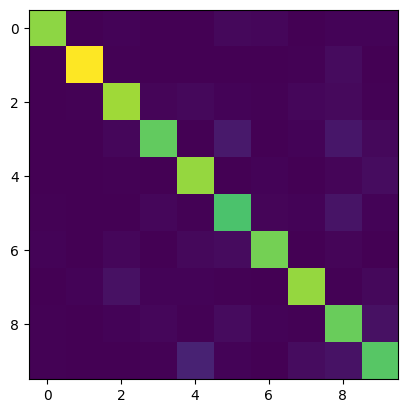

In [23]:
plt.imshow(confusion_matrix_cache)
plt.show()

Sample some images from last test batch

In [24]:
idx = {1,2,43,44,45,93,97,98,99}

prediction is 4, answer is 4


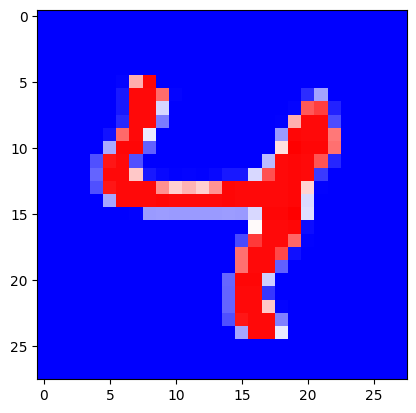

prediction is 5, answer is 5


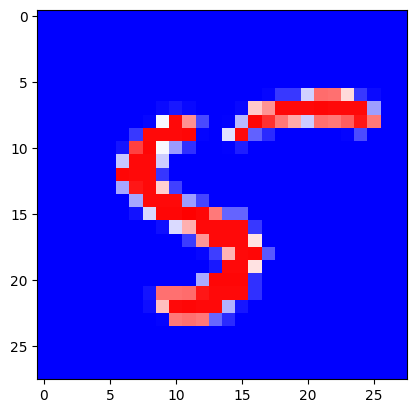

prediction is 5, answer is 5


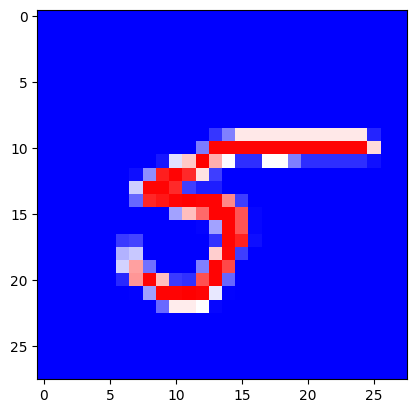

prediction is 6, answer is 6


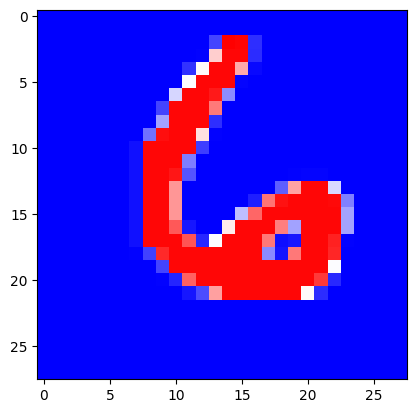

prediction is 1, answer is 1


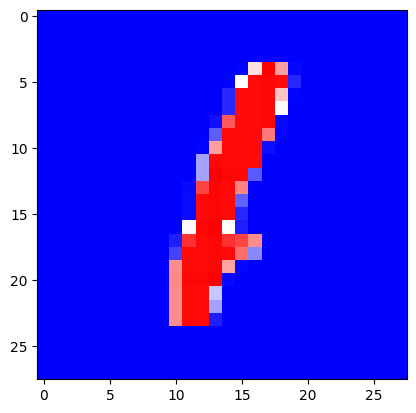

prediction is 7, answer is 9


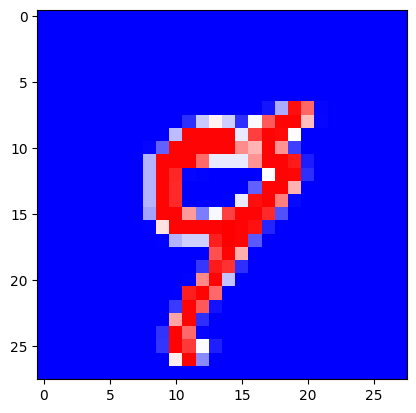

prediction is 5, answer is 5


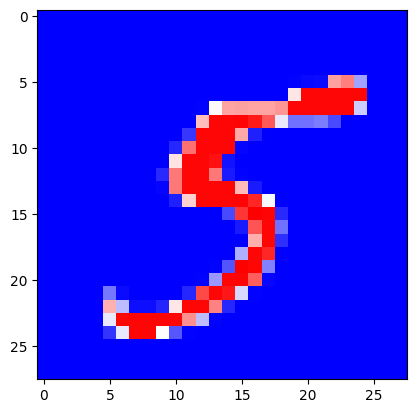

prediction is 7, answer is 7


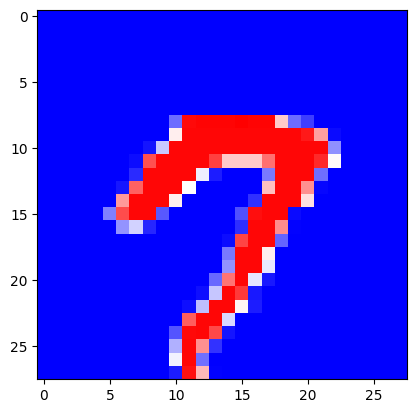

prediction is 1, answer is 1


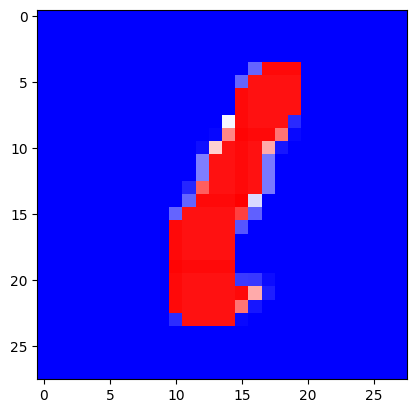

In [25]:
for id in idx:
  img = image_array[:,id].reshape(28,28)
  print(f"prediction is {np.argmax(_A2[:,id])}, answer is {label[id]}")
  plt.imshow(img,cmap='bwr')
  plt.show()

# THAT'S IT

This is the end of this note book, here we outline some todos

* Improve numerical stability of softmax function by subtracting largest matrix element before calculation
* Implement print method to output the abstract syntax tree of the neural network
* Find a better method for clearing out gradient
* Improve memory usuage by pointing value & gradient of output/input node to the same array reference
